The following code will replicate a Vision Transformer, as developed in: https://arxiv.org/abs/2010.11929

... and apply it to a classifying food categories 

This project is part of Zero-to-Mastery's: Deep Learning with Pytorch

##Get Setup 


###Importing previously written modules + required libraries

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.0+cu116
torchvision version: 0.14.0+cu116


In [ ]:
#importing some helper functions 

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves


[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3350, done.
remote: Total 3350 (delta 0), reused 0 (delta 0), pack-reused 3350
Receiving objects: 100% (3350/3350), 640.93 MiB | 33.91 MiB/s, done.
Resolving deltas: 100% (1921/1921), done.
Checking out files: 100% (221/221), done.


In [ ]:
#setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

##Getting Data Ready



###Download Data


In [ ]:
#Download the data 

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")


train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir 

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

###Turning data into dataloaders 

In [ ]:
import os 
from going_modular.going_modular import data_setup 
from torchvision import transforms 

#create an image size: VIT was trained using 224 x 224 images (table 3) 
IMG_SIZE = 224

#create transforms pipeline: change image size, and convert to tensors
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), 
    transforms.ToTensor()])

print(f'Manually created transforms: {manual_transforms}')


Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [ ]:
#Creating training and testing dataloaders using helper function: 'create_dataloaders' from 'data_setup'

#VIT initially trained with BATCH_SIZE of 4096, but we don't have the hardware...
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir, 
    test_dir = test_dir, 
    transform = manual_transforms,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS
) 
 

len(train_dataloader), len(test_dataloader), len(class_names)

(8, 3, 3)

###Let's visualize a single image to confirm the data has been properly downloaded and transformed


(-0.5, 223.5, 223.5, -0.5)

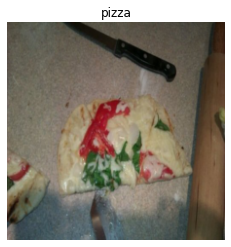

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image 
import random

#Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

#select a single image and label 
image, label = image_batch[0], label_batch[0]

#Plot the image with matplotlib 
plt.imshow(image.permute(1,2,0)) #(color_channels, height, width) --> (height, width, color_channels)
plt.title(class_names[label])  
plt.axis(False)



#Replicating the Visual Transformer architecture 



##Pieces: 
- Figure 1: Visual overview of the architectyure 
- Four equations: equations defining the functions of each layer/block 
- Table 1/3: hyperparameters for the architecture + training 

## Figure 1 
![](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-figure-1-architecture-overview.png)



## Four Equations
![](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-four-equations.png)


##Pseudocode



####Equation 1 

- x_input = [class_token, image_path_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos] 


####Equation 2 
- x_output_MSA_block = MSA_Layer(LN_Layer(x_input)) + x_input 



####Equation 3 
- x_output_MLP_block = MLP_Layer(LN_Layer(x_output_MSA_block)) + x_output_MSA_block

- MLP = 
  - one hidden layer at training time 
  - single linear layer at finetuning time 



####Equation 4
- y = Linear_layer(LN_Layer(x_output_MLP_block)))




## Table 1
![](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-table-1.png)

*Layers = Number of Transformer Encoder layers
* Hidden Size $D$ - the embedding size throughout the architecture 
*MLP size -number of hidden units in the MLP 
*Heads - multi-head self attention 


##Equation 1: Split data into patches and create the class, position, and patch embedding 

Input shape? (224, 224, 3) 
Output shape? ??? 

*Input shape: $H\times{W}\times{C}$
 --> (height, width, color_channels) 

*Output shape: ${N \times\left(P^{2} \cdot C\right)}$

*H = height 

*W = Width 

*C = color channels 

*P = patch size 

*N = number of patches = (H*W) / P^2

*D = Constant latent vector size = embedding dimension 


In [ ]:
height = 224
width = 224 
color_channels = 3
patch_size = 16
number_patches = int((height*width) / patch_size**2)
number_patches

196

In [ ]:
#input shape
embedding_layer_input_shape = (height, width, color_channels)

#output shape 
embedding_layer_output_shape = (number_patches, patch_size**2 * color_channels) 


print(f'Input shape (single 2D image: {embedding_layer_input_shape}')
print(f'Output shape (single 1D sequence of patches: {embedding_layer_output_shape} --> (number_patches, embedding_dimension)')



Input shape (single 2D image: (224, 224, 3)
Output shape (single 1D sequence of patches: (196, 768) --> (number_patches, embedding_dimension)


###Building Intuitions: Visualizing a single image in patches 

Let's visualize 

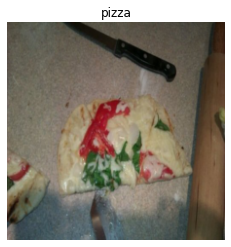

In [ ]:
#view a single imag e

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False); 

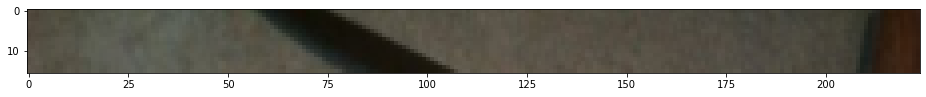

In [ ]:
#Get the top row of the image 
image_permuted = image.permute(1,2,0) #convert image to color channels last 

#index to plot the top row of pixels 
patch_size = 16 
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


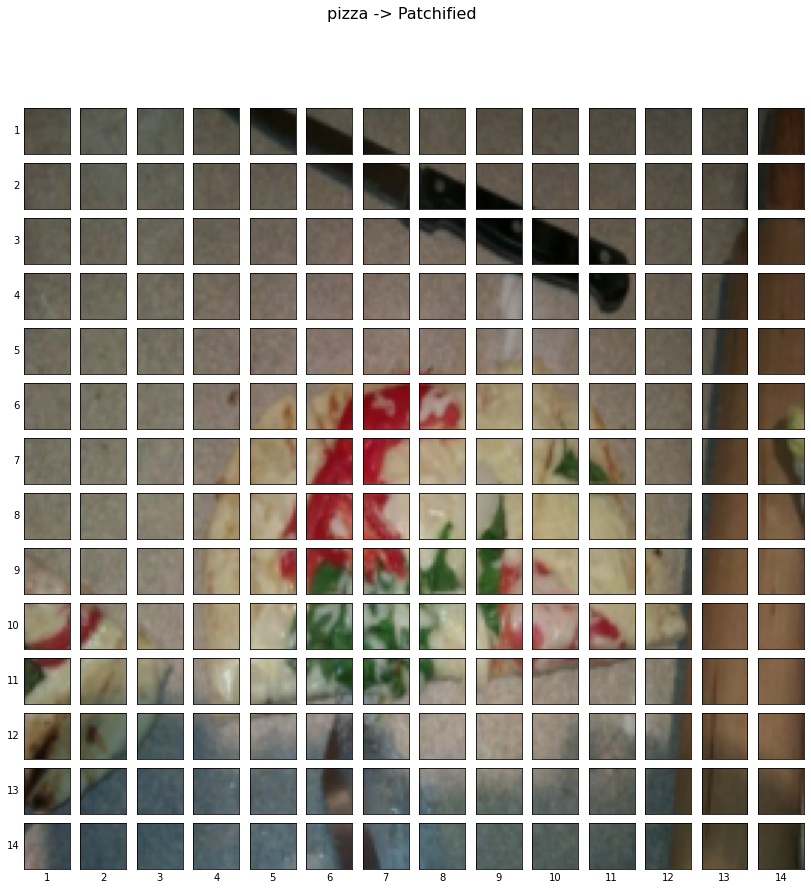

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

###Creating Image patches and turning them into patch embeddings 

Create the image patches and image patch embeddings in a single step using 'torch.nn.Conv2d()' and setting the kernel size and stride parameters to 'patch_size' 

In [ ]:
#create conv2d layer to turn image into patches of learnable feature maps
from torch import nn
patch_size = 16 

#create conv2d layer with hyperparameters from the ViT paper 
conv2d = nn.Conv2d(in_channels = 3, #for color images 
                   out_channels = 768,
                   kernel_size = patch_size, 
                   stride = patch_size, 
                   padding = 0) #D size from table one 
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

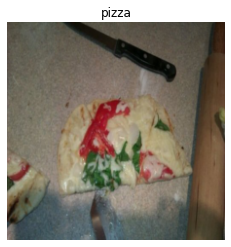

In [ ]:
#view single image 
plt.imshow(image.permute(1,2,0)) 
plt.title(class_names[label])
plt.axis(False)

In [ ]:
#Pass image through convolutional layer 

image_out_of_conv = conv2d(image.unsqueeze(0)) #Add batch dimension --> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image to our 'conv2d' layer, its shape is: 


- torch.Size([1, 768, 14, 14])

768 feature maps of size 14 x 14 


showing random convolutional feature maps from indexes: [267, 444, 419, 407, 300]


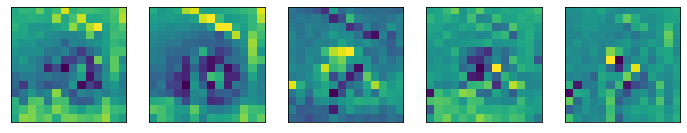

In [ ]:
#plot 5 random convolutional feature maps (embeddings)
import random 
random_indexs = random.sample(range(0, 758), k = 5)
print(f'showing random convolutional feature maps from indexes: {random_indexs}')

#create a plot 
fig, axs = plt.subplots(nrows =1, ncols = 5, figsize = (12,12))

for i, idx in enumerate(random_indexs): 
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] #index on the output tensor of the conv2d layer 
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) #remove batch dimensions and remove from grad tracking/switch to numpy for matplotlib 
  axs[i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])


In [ ]:
#Get a single feature map in tensor form 

single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0085,  0.0162, -0.0059, -0.0379,  0.0453,  0.0021,  0.0303,
            0.0103,  0.0034, -0.0016,  0.0040, -0.0037, -0.0148, -0.0247],
          [ 0.0012,  0.0017, -0.0160, -0.0055,  0.0034, -0.0212, -0.0053,
            0.0050, -0.0317,  0.0171, -0.0015,  0.0113, -0.0041, -0.0239],
          [ 0.0137,  0.0188,  0.0167,  0.0038,  0.0280,  0.0271,  0.0052,
           -0.0144, -0.0116,  0.0210, -0.0130, -0.0015,  0.0186,  0.0132],
          [ 0.0047,  0.0149,  0.0181,  0.0118,  0.0124,  0.0176,  0.0314,
            0.0168, -0.0260, -0.0537,  0.0140,  0.0039,  0.0249,  0.0270],
          [ 0.0103,  0.0093,  0.0134,  0.0370,  0.0372,  0.0201,  0.0267,
            0.0379,  0.0202,  0.0406,  0.0028,  0.0197,  0.0100,  0.0376],
          [ 0.0140,  0.0045,  0.0371,  0.0440,  0.0545,  0.0131,  0.1463,
            0.1456,  0.0425,  0.0410,  0.0225,  0.0100,  0.0017,  0.0286],
          [ 0.0071,  0.0219,  0.0019,  0.0555,  0.0768,  0.0685,  0.0606,
            0.0282,  0.0328,  0.

### Flattening the patch embedding with torch.nn.Flatten()

Right now we've got a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder

In [ ]:
print(f'{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)')

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


Want: (batch_size, number_of_patches, embedding_dim) 

In [ ]:
from torch import nn 
flatten_layer = nn.Flatten(start_dim = 2, 
                           end_dim = 3)


 

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


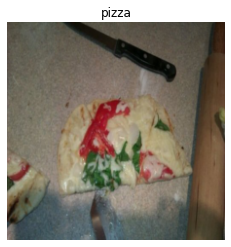

In [ ]:
#put everything together 
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f'Original image shape: {image.shape}')

#Turn image into featuer maps  
image_out_of_conv = conv2d(image.unsqueeze(0)) #Add batch dimension
print(f'Image feature map (patches) shape: {image_out_of_conv.shape}')

#Flatten the feature maps 
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f'Flattened image feature map shape: {image_out_of_conv_flattened.shape}')

In [ ]:
#Rearrange output of flattened layer 
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
print(f'{image_out_of_conv_flattened.permute(0,2,1).shape} _> (batch_size, number_of_patches,embedding dim)')

torch.Size([1, 196, 768]) _> (batch_size, number_of_patches,embedding dim)


Text(0.5, 1.0, 'Flattened feature map shape: torch.Size([1, 196])')

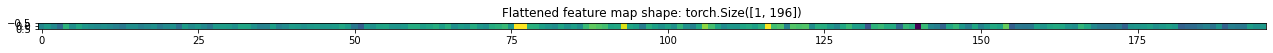

In [ ]:
#Get a single flattened featuer map 
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:,:,0]

#plot the flattened feautre map visually 
plt.figure(figsize = (22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattened_feature_map.shape}')

Turning the ViT patch embedding layer into a Pytorch module 

In [ ]:
class PatchEmbedding(nn.Module):
    #initialize layer with appropriate hyperparaemeters
    def __init__(self, 
                 in_channels: int = 3, 
                 patch_size: int = 16,
                 embedding_dim: int = 768): 
      super().__init__()

      #create a layer to turn an image into embedded patches
      self.patcher = nn.Conv2d(
                    in_channels = in_channels, #for color images 
                    out_channels = embedding_dim,
                    kernel_size = patch_size, 
                    stride = patch_size, 
                    padding = 0)

      #create a layer to flatten the patches into a sequence of patches 
      self.flatten = nn.Flatten(
                          start_dim = 2, 
                           end_dim = 3)
      

    #define forward computation steps 
    def forward(self, x): 
      #create assertion to check that inputs are the correct shape 
      image_resolution = x.shape[-1]
      assert image_resolution % patch_size == 0, f'Input image size must be divisble by patch size'
      
      x_patched = self.patcher(x)
      x_flattened = self.flatten(x_patched)
      x_permuted = x_flattened.permute(0,2,1)
      return x_permuted
  

    



In [ ]:
set_seeds()

#create an instance of patch embedding layer 

patchify = PatchEmbedding(in_channels = 3, 
                          patch_size = 16, 
                          embedding_dim = 768
                          )

#pass single through patch embedding layer 
print(f'Input image size: {image.unsqueeze(0).shape}')
patch_embedded_image = patchify(image.unsqueeze(0))
print(f'Output patch embedding sequence shape {patch_embedded_image.shape}')



Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape torch.Size([1, 196, 768])


In [ ]:
#Checking that our assertion clause works 
rand_image_tensor = torch.randn(1,3,224,224)
rand_image_tensor_bad = torch.randn(1,3,250,250)

#patchify(rand_image_tensor), patchify(rand_image_tensor_bad)

AssertionError: ignored

### Creating the class token embedding 

Want to: prepend a learnable class token to the start of the patch embedding 


In [ ]:
#Get the batch size and embedding dimension 
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

batch_size, embedding_dimension

(1, 768)

In [ ]:
#create the class token embedding as a learnable parameter that shares the same size as the embdding dimension 
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), 
                           requires_grad = True)#Use ones for visibility to start 


class_token.shape                     

torch.Size([1, 1, 768])

In [ ]:
patch_embedded_image.shape[1]

196

In [ ]:
#Add the class embedding to the front of the patch embedding 
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim = 1) #number_of_patches dimension 

print(patch_embedded_image_with_class_embedding)                                              
print(f'sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} --> (batch_size, class_token + number of patches, embedding dimension)')

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.3628,  0.0832, -0.1194,  ...,  0.2483, -0.1313,  0.1239],
         [-0.3764,  0.0970, -0.1314,  ...,  0.2792, -0.1587,  0.1437],
         ...,
         [-0.2833,  0.0011, -0.0763,  ...,  0.2170, -0.1530,  0.1150],
         [-0.3032,  0.0506, -0.1199,  ...,  0.1977, -0.1149,  0.1284],
         [-0.2231,  0.0555, -0.0902,  ...,  0.1475, -0.0960,  0.1455]]],
       grad_fn=<CatBackward0>)
sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) --> (batch_size, class_token + number of patches, embedding dimension)


In [ ]:
patch_embedded_image_with_class_embedding[0][0].shape

torch.Size([768])

### Creating the position embedding 

Want to create a series of 1D learnable position embeddings and add them to the sequence of patch embeddings 

In [ ]:
#Calculate N (number of patches)

number_of_patches = int((height*width) / patch_size **2)

#Get the embedding dimension 
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

position_embedding = nn.Parameter(torch.ones(batch_size,
                                             number_of_patches+1,
                                             embedding_dimension), 
                           requires_grad = True)#Use ones for visibility to start 

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

print(patch_and_position_embedding)
print(patch_and_position_embedding.shape)

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.6372, 1.0832, 0.8806,  ..., 1.2483, 0.8687, 1.1239],
         [0.6236, 1.0970, 0.8686,  ..., 1.2792, 0.8413, 1.1437],
         ...,
         [0.7167, 1.0011, 0.9237,  ..., 1.2170, 0.8470, 1.1150],
         [0.6968, 1.0506, 0.8801,  ..., 1.1977, 0.8851, 1.1284],
         [0.7769, 1.0555, 0.9098,  ..., 1.1475, 0.9040, 1.1455]]],
       grad_fn=<AddBackward0>)
torch.Size([1, 197, 768])


### Putting it all together: from image to embedding  

We've written code to turn an image in a flattened sequence of patch embeddings. 

Now let's see it all together


In [ ]:
set_seeds() 

patch_size = 16

#print shape of original image tensor and get the image dimensions 
print(f'Image tensor shape: {image.shape}')
height, width = image.shape[1], image.shape[2]

#get image tensor and add batch dimension 
x = image.unsqueeze(0)
print(f'shape of input image with batch dimension: {x.shape} ')

#Create a PatchEmbedding class to turn image into sequence of embedded patches 
class PatchEmbedding(nn.Module):
    #initialize layer with appropriate hyperparaemeters
    def __init__(self, 
                 in_channels: int = 3, 
                 patch_size: int = 16,
                 embedding_dim: int = 768): 
      super().__init__()

      #create a layer to turn an image into embedded patches
      self.patcher = nn.Conv2d(
                    in_channels = in_channels, #for color images 
                    out_channels = embedding_dim,
                    kernel_size = patch_size, 
                    stride = patch_size, 
                    padding = 0)

      #create a layer to flatten the patches into a sequence of patches 
      self.flatten = nn.Flatten(
                          start_dim = 2, 
                           end_dim = 3)
      

    #define forward computation steps 
    def forward(self, x): 
      #create assertion to check that inputs are the correct shape 
      image_resolution = x.shape[-1]
      assert image_resolution % patch_size == 0, f'Input image size must be divisble by patch size'
      
      x_patched = self.patcher(x)
      x_flattened = self.flatten(x_patched)
      x_permuted = x_flattened.permute(0,2,1)
      return x_permuted


patch_embedding_layer = PatchEmbedding(in_channels = 3, 
                          patch_size = patch_size, 
                          embedding_dim = 768
                          )

#Pass through image through patch embedding layer 
patch_embedding = patch_embedding_layer(x)
print(f'Patch embedding shape: {patch_embedding.shape}')



#Creating the class token embedding 

#Getting the batch size and embedding dimension 
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), 
                           requires_grad = True)#Use ones for visibility to start 
print(f'Class token embedding shape: {class_token.shape}')

#Add the class embedding to the front of the patch embedding 
patch_embedding_class_token = torch.cat((class_token, patch_embedded_image), 
                                                      dim = 1) #number_of_patches dimension 
print(f'Patch embedding with class token shape: {patch_embedding_class_token.shape}')

#Creating the position embedding
number_of_patches = int((height*width) / patch_size **2)
position_embedding = nn.Parameter(torch.ones(batch_size,
                                             number_of_patches+1,
                                             embedding_dimension), 
                           requires_grad = True)#Use ones for visibility to start 

# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedding_class_token + position_embedding


print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

Image tensor shape: torch.Size([3, 224, 224])
shape of input image with batch dimension: torch.Size([1, 3, 224, 224]) 
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [ ]:
#adding to the  PatchEmbedding class

class PatchPositionEmbedding(nn.Module):
    #initialize layer with appropriate hyperparaemeters
    def __init__(self, 
                 in_channels: int = 3, 
                 patch_size: int = 16,
                 embedding_dim: int = 768): 
      super().__init__()
      self.embedding_dim = embedding_dim 
      self.patch_size = patch_size 
      #self.batch_size = 

      #create a layer to turn an image into embedded patches
      self.patcher = nn.Conv2d(
                    in_channels = in_channels, #for color images 
                    out_channels = embedding_dim,
                    kernel_size = patch_size, 
                    stride = patch_size, 
                    padding = 0)

      #create a layer to flatten the patches into a sequence of patches 
      self.flatten = nn.Flatten(
                          start_dim = 2, 
                           end_dim = 3)
      
      self.class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), 
                           requires_grad = True)#Use ones for visibility to start 

      self.position_embedding = nn.Parameter(torch.ones(batch_size,
                                             number_of_patches+1,
                                             embedding_dimension), 
                                              requires_grad = True)#Use ones for visibility to start 
    #define forward computation steps 
    def forward(self, x): 
      #create assertion to check that inputs are the correct shape 
      image_resolution = x.shape[-1]
      assert image_resolution % patch_size == 0, f'Input image size must be divisble by patch size'


      x_patched = self.patcher(x)
      x_flattened = self.flatten(x_patched)
      x_permuted = x_flattened.permute(0,2,1)
      #Add the class embedding to the front of the patch embedding 
      patch_embedding_class_token = torch.cat((self.class_token, 
                                               x_permuted), 
                                                dim = 1) #number_of_patches dimension 

      height, width = x.shape[1], x.shape[2] 
      number_of_patches = int((height*width) / patch_size **2)

      patch_and_position_embedding = patch_embedding_class_token + self.position_embedding

      return patch_and_position_embedding




In [ ]:
patch_and_position_embedding_layer = PatchPositionEmbedding(in_channels = 3, 
                          patch_size = patch_size, 
                          embedding_dim = 768
                          )

In [ ]:
patch_and_position_embedding = patch_and_position_embedding_layer(x)
patch_and_position_embedding 

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.2217, 0.9361, 0.7111,  ..., 1.2945, 1.1025, 1.0055],
         [1.2577, 0.9162, 0.6640,  ..., 1.3227, 1.0987, 0.9831],
         ...,
         [1.1454, 0.9683, 0.7249,  ..., 1.1982, 1.0908, 1.0342],
         [1.1938, 0.9485, 0.7539,  ..., 1.2644, 1.0650, 0.9831],
         [1.1491, 0.9482, 0.7907,  ..., 1.1775, 1.0714, 1.0557]]],
       grad_fn=<AddBackward0>)

## Equation 2: Multihead Self-Attention (MSA block) 

* Multihead Self Attention: Which patch significantly relates to another patch? We want our ViT to learn this relationship 
*To replicate MSA in pytorch we can use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html


*Layernorm: Technique to normlize the distributions of intermediate layers, enabling smoother gradients, faster training, and better generalization accuracy ...: 
*We can use: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

In [ ]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:int=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [ ]:
#Create an instance of MSA block 
multihead_self_attention_block = MultiheadSelfAttentionBlock()

#Pass the patch and position image embedding sequence through MSA block 
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding )

print(patch_and_position_embedding.shape)
print(patched_image_through_msa_block.shape)


torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


###Create the MLP Block 

**MLP** = the MLP contains two layers with a GELU non-linearity 


In [ ]:
from torchvision import ops 
 # 1. Create a class that inherits from nn.Module

class MLPBlock(nn.Module):
    """Creates a multi-layer percpetron block ("MLP block" for short).
    """
    # Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim: int = 768,
                 mlp_size: int = 3072, 
                 dropout: int = .1):
                 #activation_layer: nn.Module = torch.nn.GELU): # doesn't look like the paper uses any dropout in MSABlocks
      super().__init__()

      self.layer_norm = nn.LayerNorm(embedding_dim)
      self.MLP_Block = nn.Sequential(
          nn.Linear(in_features = embedding_dim, 
                    out_features = mlp_size),
          nn.GELU(),
          nn.Dropout(p = dropout),
          nn.Linear(in_features = mlp_size, 
                    out_features = embedding_dim),
          nn.Dropout(p = dropout)
      )
       

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):

      return  self.MLP_Block(self.layer_norm(x))

In [ ]:
mlp_block = MLPBlock()
patched_image_through_MLP_block = mlp_block(patched_image_through_msa_block)
patched_image_through_MLP_block.shape

torch.Size([1, 197, 768])

###Create a Custom Transformer Block 
The Transformer Encoder is a combination fo alternating blocks of MSA (eq 2) and MLP (eq 3) 



In [ ]:
class TransformerEncoderBlock (nn.Module):
  """ creates a transformer Encoder block. """ 
  def __init__(self,
                 embedding_dim: int = 768,
                  num_heads:int=12, # Heads from Table 1 for ViT-Base
                  attn_dropout:int=0,
                  mlp_size: int = 3072, 
                  mlp_dropout: int = .1):
      super().__init__()

      self.msa_block = MultiheadSelfAttentionBlock(
          embedding_dim = embedding_dim, 
          num_heads = num_heads, 
          attn_dropout = attn_dropout 
      )

      self.mlp_block = MLPBlock(
          embedding_dim = embedding_dim, 
          mlp_size = mlp_size, 
          dropout = mlp_dropout
      )

  def forward(self, x): 
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x 
    return x 


In [ ]:
#Create an instance of TransformerEncoderBlock 
transformer_encoder_block = TransformerEncoderBlock()

#get a summary 
summary(model = transformer_encoder_block, 
        input_size = (1,197, 768),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'] 
        ) #Batch 


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
TransformerEncoderBlock                  [1, 197, 768]             [1, 197, 768]             --                        True
├─MultiheadSelfAttentionBlock: 1-1       [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm: 2-1                    [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─MultiheadAttention: 2-2           --                        [1, 197, 768]             2,362,368                 True
├─MLPBlock: 1-2                          [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm: 2-3                    [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─Sequential: 2-4                   [1, 197, 768]             [1, 197, 768]             --                        True
│  

### Create a transformer Encoder Layer in-built Pytorch layers  

So far we've created a transformer encoder layer with in built pytorch transformer encoder layers: 

https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html



In [ ]:
#Create the same as above with torch.nn.TransformerEncoderLayer()

torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768, #embedding dimension
                                                              nhead = 12, #Heads from table one 
                                                              dim_feedforward = 3072,  
                                                              dropout = .1, 
                                                              activation = 'gelu',
                                                              batch_first = True, 
                                                              norm_first = True
                                                              )


torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
#get a summary 
summary(model = torch_transformer_encoder_layer, 
        input_size = (1,197, 768),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        
        row_settings = ['var_names']
        ) #Batch 

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## Putting it all together to create ViT 

In [ ]:
#Create a ViT class

class ViT(nn.Module):
  def __init__(self,
               img_size: int = 224, 
               in_channels: int = 3, 
               patch_size: int = 16, 
               num_transformer_layers: int = 12, #Table 1 layers for BiT Base 
               embedding_dim: int = 768, #Hidden size D from table 1 for ViT-Base
               mlp_size: int = 3072, 
               num_heads: int = 12, 
               attn_dropout: int = 0, 
               mlp_dropout: int = .1,
               embedding_dropout: int = .1,
               num_classes: int = 1000


               ): 
    super().__init__()

    #Make assertion that the image size is divisible with patch size
    assert img_size % patch_size == 0, f'Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}'
    
    #calculate number of patches 
    self.num_patches = (img_size * img_size // patch_size ** 2)

    #Create lernable classs embedding 
    self.class_embedding = nn.Parameter(data=torch.randn(1,1, embedding_dim), 
                                        requires_grad = True)
    
    #create learnable position embedding 
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim))

    #Create embedding dropout value 
    self.embedding_dropout = nn.Dropout(p = embedding_dropout)

    #Create patch embedding layer 
    self.patch_embedding = PatchEmbedding(
        in_channels = in_channels, 
        patch_size = patch_size, 
        embedding_dim = embedding_dim 
    )

    #Create Trasnformer encoder block by stacking 12 encoder layers 

    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(
        embedding_dim = embedding_dim, 
        num_heads = num_heads, 
        mlp_size = mlp_size,
        mlp_dropout = mlp_dropout) for _ in range(num_transformer_layers)])

  
    #Create classifier head

    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape = embedding_dim), 
        nn.Linear(in_features=embedding_dim, 
                  out_features = num_classes)
                      
    ) 

  def forward(self, x):
      #Get the batch size 
      batch_size = x.shape[0]

      #Create class token embedding and expand it to match the batch size 
      class_token = self.class_embedding.expand(batch_size, -1, -1) #-1 means to inferr the dimensions 

      #Create patch embedding
      x = self.patch_embedding(x)

      #Concat class token embedding and patch embedding
      x = torch.cat((class_token, x), dim = 1)

      #Add position embedding to class token and patch embedding
      x = self.position_embedding + x
      
      #Apply dropout to patch embeddings  
      x = self.embedding_dropout(x)

      #Pass position and patch embedding to our Transformer Encoder
      x = self.transformer_encoder(x)

      #Put 0th index logit through the classifier (Eq. 4)
      x = self.classifier(x[:,0]) #Every batch, and the 0th index 

      return x 





In [ ]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiheadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (MLP_Block): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
  

##Run data through the VIT class  

In [ ]:

#Create a random image tensor with same shape as a single image

random_image_tensor = torch.randn(1,3,224,224)

#Create an instance of ViT with the number of classes we're woring with (Pizza, steak, sushi)
vit = ViT(num_classes = len(class_names))

vit(random_image_tensor)

tensor([[-0.6439,  0.6213, -0.5782]], grad_fn=<AddmmBackward0>)

Doesn't work ... becuase haven't trained!! 

## Getting a visual summary of ouir ViT model 


In [ ]:
from torchinfo import summary


summary(model = ViT(num_classes = 1000), 
        input_size = (1,3, 224, 224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'] 
        ) #

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
ViT                                                [1, 3, 224, 224]          [1, 1000]                 152,064                   True
├─PatchEmbedding: 1-1                              [1, 3, 224, 224]          [1, 196, 768]             --                        True
│    └─Conv2d: 2-1                                 [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   True
│    └─Flatten: 2-2                                [1, 768, 14, 14]          [1, 768, 196]             --                        --
├─Dropout: 1-2                                     [1, 197, 768]             [1, 197, 768]             --                        --
├─Sequential: 1-3                                  [1, 197, 768]             [1, 197, 768]             --                        True
│    └─TransformerEncoderBlock: 2-3                [1, 197, 7

##Setting up training code on our custom ViT 


###Creating an optimizer 

Paper states it using Adam optimizer with B1 = .9, B2 = .999 and weigth decay of 0.1

In [ ]:
vit_model1 = ViT(num_classes = 3)


In [ ]:
#Optimizer 
optimizer = torch.optim.Adam(params = vit_model1.parameters(), 
                            lr= .001, 
                             betas = (.9, .999), 
                            weight_decay = .1,
                             )

###Creating a loss function 

ViT paper doesn't mention loss function they use. Since it's multiclass classification, we'll use cross entropy loss 

In [ ]:
 
loss_fn = torch.nn.CrossEntropyLoss()


##Training our model 

In [ ]:
from going_modular.going_modular import engine


#Train 
results = engine.train(vit_model1, 
             train_dataloader = train_dataloader,
             test_dataloader = test_dataloader, 
             optimizer = optimizer, 
             loss_fn = loss_fn,
             epochs = 3, 
             device = device
             )


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6239 | train_acc: 0.2852 | test_loss: 1.4775 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.3406 | train_acc: 0.4375 | test_loss: 1.5691 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.6358 | train_acc: 0.2695 | test_loss: 1.3600 | test_acc: 0.2604


### What our training setup is missing? 

Why do we get poor results when the ViT paper gets gereat results ? 

Prevent Underfitting
* Data: They use waaaay more data 

Prevent overfitting
*learning rate warmup 
*learning rate decay 
* Gradient clipping - prevent gradients from getting too big 







###Plotting loss curves for our model 

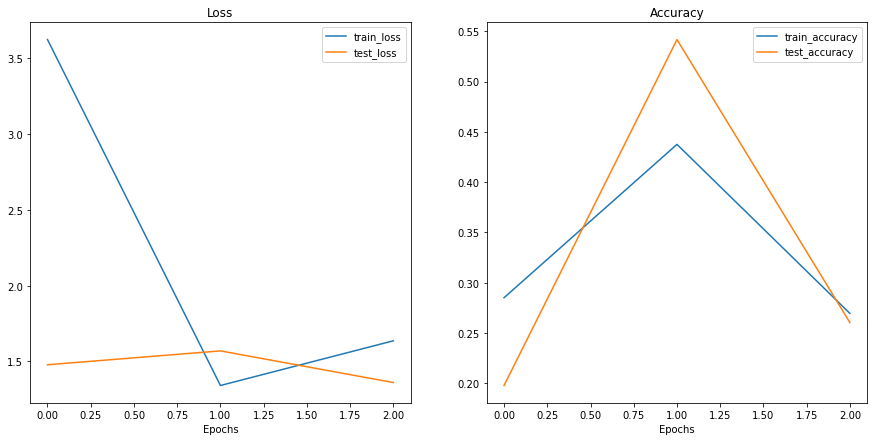

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

We are both underfitting and overfitting right now .. 

##Let's try and use transfer learning by finding a pre-trained vision transformer ... 


In [ ]:
from torchvision import models

device = 'cuda' if torch.cuda.is_available() else 'cpu'




In [ ]:
weights = models.ViT_B_16_Weights.DEFAULT

pretrained_vit = models.vit_b_16(weights = weights).to(device)



Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [ ]:
#Freeze the base parameters  

for param in pretrained_vit.parameters(): 
  param.requires_grad = False 

#Update the classifier head 
set_seeds() 
pretrained_vit.heads = nn.Linear(in_features = 768, out_features = 3)


In [ ]:
 
summary(model = pretrained_vit, 
        input_size = (1,3, 224, 224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width = 20, 
        row_settings = ['var_names']
        ) #


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

###FineTuning the pretrained model 

####Preparing the data the same way that the data used to train the original model was prepared 

In [ ]:
#get the transformstoins used on the data used to train the pretrained ViT  model 
vit_transforms = weights.transforms()
vit_transforms


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:

#Create train and test dataloader 
from going_modular.going_modular import data_setup


train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir = train_dir, 
    test_dir = test_dir, 
    transform = vit_transforms, 
    batch_size = 32 #Could use a higher batch size because using pretrianed model 
)

In [ ]:
from going_modular.going_modular import engine


loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = pretrained_vit.parameters(), 
                            lr= .001, 
                             )


set_seeds()
#Train 
pretrained_vit_results = engine.train(pretrained_vit, 
             train_dataloader = train_dataloader_pretrained,
             test_dataloader = test_dataloader_pretrained, 
             optimizer = optimizer, 
             loss_fn = loss_fn,
             epochs = 3, 
             device = device
             )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081


##Plot loss cuves of our pretrained ViT model 

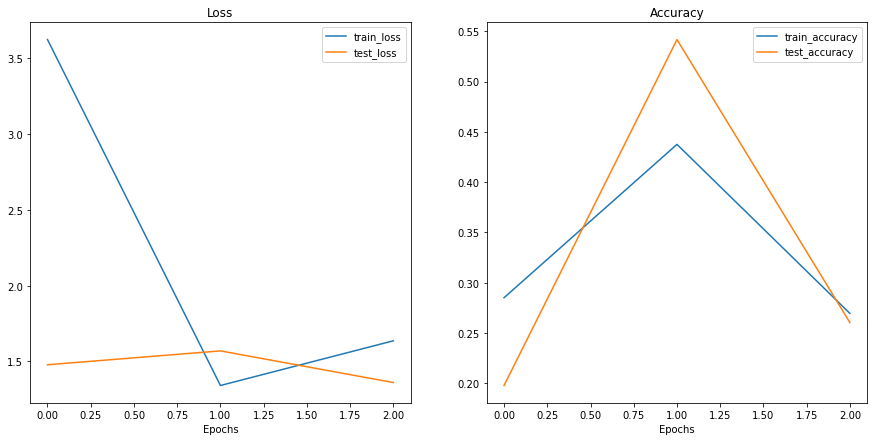

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

Much better loss and accuracy curves

##Save the best performing ViT model 


In [ ]:
from going_modular.going_modular import utils 

utils.save_model(model = pretrained_vit, 
                 target_dir = 'models', 
                 model_name = 'pretrained_vit_feature_extractor_pizza_steak_sushi.pth')

In [ ]:
#Check model size

from pathlib import Path

pretrained_vit_model_size = Path('models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth').stat().st_size // (1024 * 1024)
print(f'Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB')

Pretrained ViT gets some of the best results, but the model size is 11X larger than our next best performing model 


## Predicting on a Custom image 

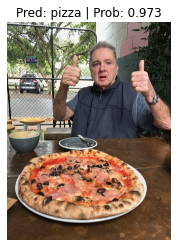

In [ ]:
#Download custom image
import requests
from going_modular.going_modular import predictions 


#setup custom image path 
custom_image_path = image_path / '04-pizza-dad.jpeg'

#download the image if it doesn't exist 
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f: 
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    f.write(request.content)

else: 
  print(f'{custom_image_path} already exists, skipping download')

#Predict on custom image 

predictions.pred_and_plot_image(model = pretrained_vit, 
                                class_names = class_names, 
                                image_path = custom_image_path)  

